In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from BiasedErasure.delayed_erasure_decoders.Experimental_Loss_Decoder import *
from BiasedErasure.main_code.Simulator import *
from BiasedErasure.main_code.noise_channels import atom_array
from BiasedErasure.delayed_erasure_decoders.HeraldedCircuit_SWAP_LD import HeraldedCircuit_SWAP_LD


In [2]:
def simulate(noise_params={}, chunk_size=10000, noise_scales=[1.,1.,1.,1.], distance=5):
    cycles = 4
    decoder_basis = 'Z'
    num_rounds = 5
    gate_ordering = ['N', 'Z', 'Zr', 'Nr']
    Meta_params = {'architecture': 'CBQC', 'code': 'Rotated_Surface', 'logical_basis': decoder_basis, 'bias_preserving_gates': 'False', 
        'noise': 'atom_array', 'is_erasure_biased': 'False', 'LD_freq': '100', 'LD_method': 'None', 'SSR': 'True', 'cycles': str(num_rounds - 1),
            'ordering': gate_ordering,
            'decoder': 'ML',
        'circuit_type': 'memory', 'Steane_type': 'regular', 'printing': 'False', 'num_logicals': '1', 'loss_decoder': 'independent', 'obs_pos': 'd-1', 'n_r': '0'}
    bloch_point_params = {'erasure_ratio': '1', 'bias_ratio': '0.5'}
    
    # Example data, change this:
    dx = distance
    dy = distance
    
    output_dir = ""
    simulator = Simulator(Meta_params=Meta_params, atom_array_sim=True, 
                                bloch_point_params=bloch_point_params, noise=atom_array , 
                                phys_err_vec=None, loss_detection_method=HeraldedCircuit_SWAP_LD, 
                                cycles = cycles, output_dir=output_dir, save_filename=None, save_data_during_sim=False)
    
    meas, det = simulator.sampling_with_loss(chunk_size, dx, dy, None, noise_params=noise_params)
    return torch.Tensor(meas).int(), torch.Tensor(det).int()

In [3]:
def p_ij_matrix(detections: np.ndarray, d:int) -> np.ndarray:
    num_ancillas = d**2-1
    num_time_steps = 4
    total_steps = num_ancillas * num_time_steps
    
    p_ij = np.zeros((total_steps, total_steps))
    x_avg = np.mean(detections, axis=0)
    xixj_avg_matrix = np.dot(detections.T, detections) / detections.shape[0]
    for idx_i in range(total_steps):
        for idx_j in range(idx_i + 1, total_steps):
            xi_avg = x_avg[idx_i]
            xj_avg = x_avg[idx_j]
            xixj_avg = xixj_avg_matrix[idx_i, idx_j]
            numerator = 4 * (xixj_avg - xi_avg * xj_avg)
            denominator = 1 - 2 * xi_avg - 2 * xj_avg + 4 * xixj_avg
            if denominator > 0 and 1 - numerator / denominator >= 0:
                value = 0.5 - 0.5 * np.sqrt(1 - numerator / denominator)
                p_ij[idx_i, idx_j] = value
                p_ij[idx_j, idx_i] = value  # The matrix is symmetric
    return np.round(p_ij, 3)

In [4]:
# from tqdm.auto import *
# maximums = np.array([
#         3e-6, *[8e-6]*3, *[0.05/4]*3, *[0.05/4]*15, 0.05/4, *[1e-3]*3, 0.03, 0.04 
#     ])
# to_dict = lambda noise_params: dict(
#         idle_loss_rate=noise_params[0],
#         idle_error_rate=noise_params[1:4],
#         entangling_zone_error_rate=noise_params[4:7],
#         entangling_gate_error_rate=noise_params[7:22],
#         entangling_gate_loss_rate=noise_params[22],
#         single_qubit_error_rate=noise_params[23:26],
#         reset_error_rate=noise_params[26],
#         measurement_error_rate=noise_params[27]
#     )
# keys = ['idle_loss_rate', *['idle_error_rate']*3, *['entangling_zone_error_rate']*3, 
#         *['entangling_gate_error_rate']*15, 'entangling_gate_loss_rate', *['single_qubit_error_rate']*3,
#         'reset_error_rate', 'measurement_error_rate'
#         ]
# fig, axes = plt.subplots(4,7,figsize=(10,5))
# axes = axes.flatten()
# for i in trange(28):
#     x = np.zeros(28)
#     x[i] = maximums[i]/5
#     meas, det = simulate(noise_params=to_dict(x), chunk_size=20000)
#     cov_ = p_ij_matrix(det.numpy()).flatten()
#     cov_ /= np.linalg.norm(cov_)
#     tmp = int(np.sqrt(len(cov_)))
#     axes[i].imshow(cov_.reshape((tmp,tmp)))
#     axes[i].axis('off')
#     axes[i].set_title(f'{keys[i]}', fontsize=5)

# fig.tight_layout()

In [7]:
from tqdm.auto import *
maximums = np.array([
        3e-6, *[8e-6]*3, *[0.05/4]*3, *[0.05/4]*15, 0.05/4, *[1e-3]*3, 0.03, 0.04 
    ])
to_dict = lambda noise_params: dict(
        idle_loss_rate=noise_params[0],
        idle_error_rate=noise_params[1:4],
        entangling_zone_error_rate=noise_params[4:7],
        entangling_gate_error_rate=noise_params[7:22],
        entangling_gate_loss_rate=noise_params[22],
        single_qubit_error_rate=noise_params[23:26],
        reset_error_rate=noise_params[26],
        measurement_error_rate=noise_params[27]
    )
keys = ['idle_loss_rate', *['idle_error_rate']*3, *['entangling_zone_error_rate']*3, 
        *['entangling_gate_error_rate']*15, 'entangling_gate_loss_rate', *['single_qubit_error_rate']*3,
        'reset_error_rate', 'measurement_error_rate'
        ]
fig  = plt.figure()
d=5

i=0 # specific error only
x = np.zeros(28)
x[i] = maximums[i]/5
x = maximums / 5
meas, det = simulate(noise_params=to_dict(x), chunk_size=10000, distance = d)
cov_ = p_ij_matrix(det.numpy(), d=d).flatten()
cov_ /= np.linalg.norm(cov_)
tmp = int(np.sqrt(len(cov_)))
plt.imshow(cov_.reshape((tmp,tmp)))

fig.tight_layout()

entangling Pauli error rate = None, entangling loss rate = None
Using orderings: ['N', 'Z', 'Zr', 'Nr']
/loss_circuits/CBQC__Rotated_Surface__memory__1log__Z__0__atom_array__0__LD_freq_100__SSR_1__LD_method_None__ordering_N_Z_Zr_Nr/dx_5__dy_5__c_4
0 1 

TypeError: Invalid shape (9216,) for image data

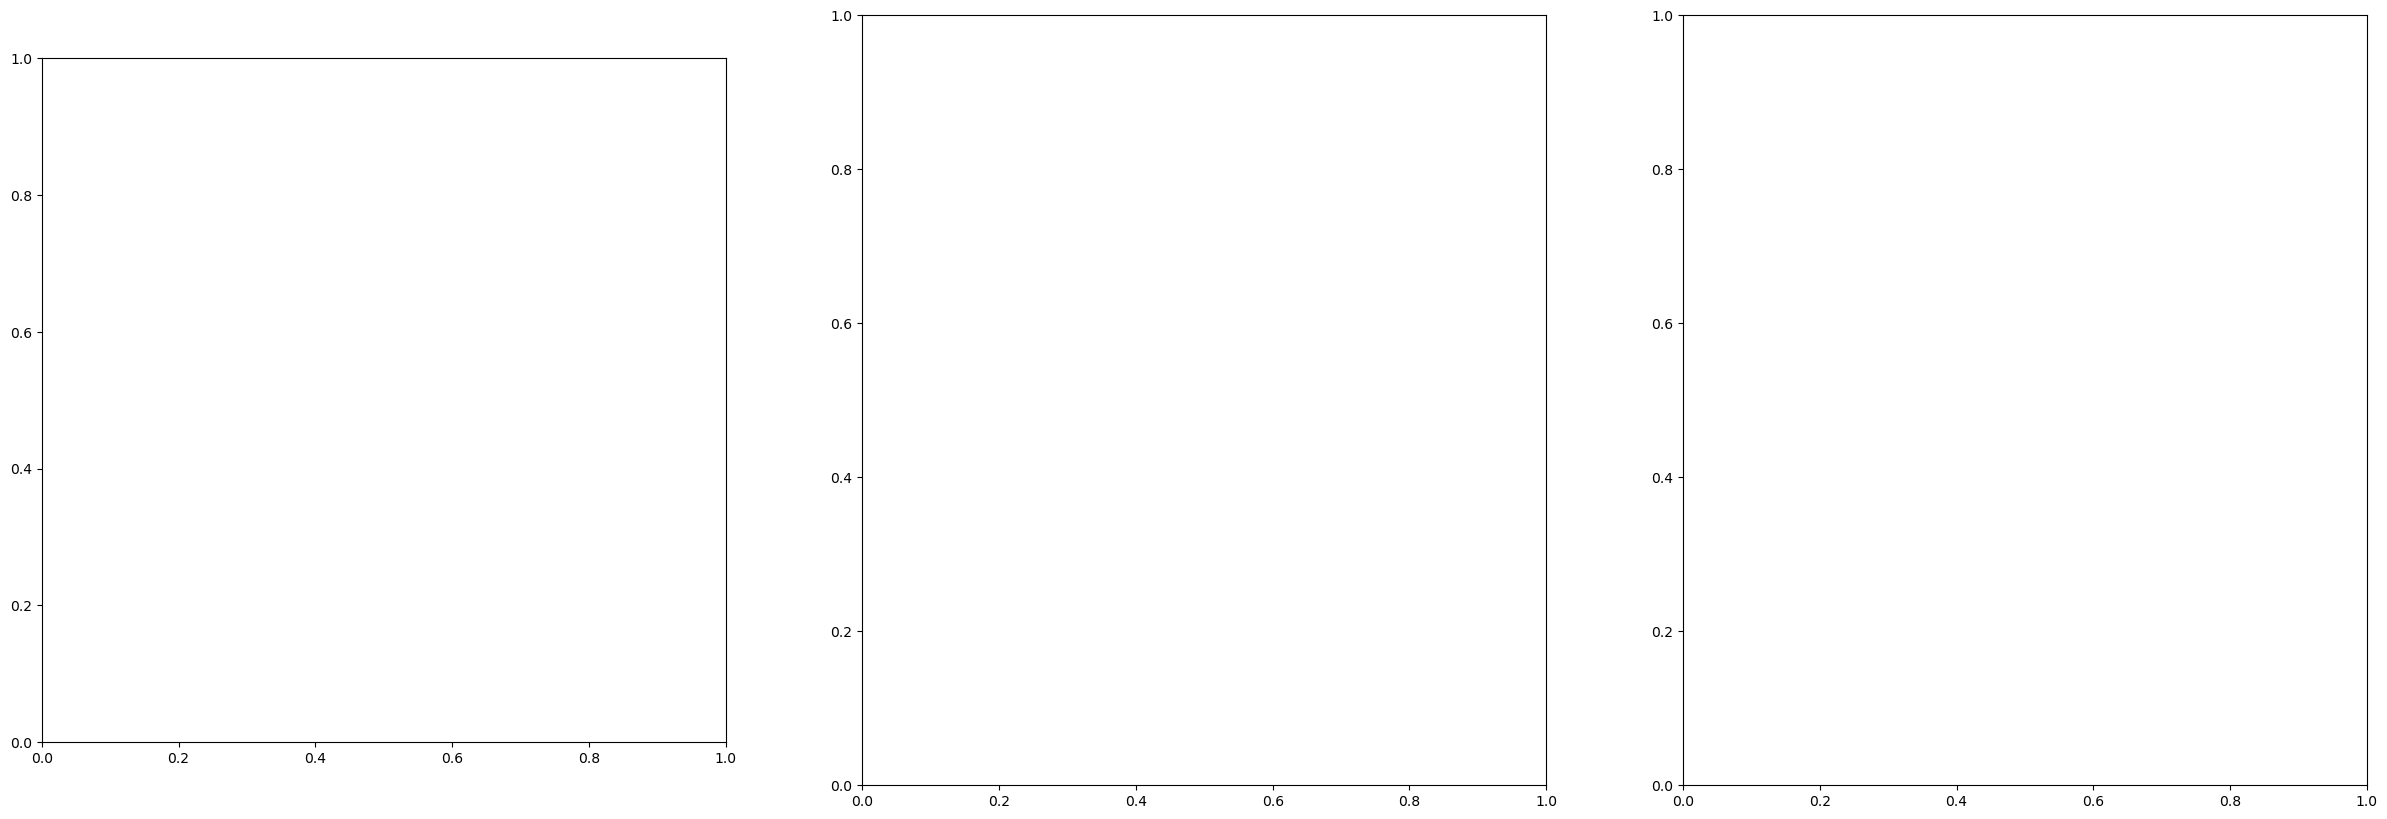

In [ ]:
def generate_ticks_labels_gridlines(distance=3, num_time_steps=5):
    tick_positions = []
    tick_labels = []
    grid_lines = []

    current_pos = 0
    num_detectors = distance**2 - 1
    for detector in range(num_detectors):
        tick_positions.extend([current_pos + i for i in range(num_time_steps)])
        tick_labels.extend([f'D{detector}'] + [''] * (num_time_steps - 1))
        current_pos += num_time_steps
        grid_lines.append(current_pos - 0.5)

    return tick_positions, tick_labels, grid_lines

def plot_correlation_matrices(pij_experiment, pij_simulated, pij_difference):
    fig, axes = plt.subplots(1, 3, figsize=(30, 10))

    # Generate ticks, labels, and grid lines
    ticks, tick_labels, grid_lines = generate_ticks_labels_gridlines()
    
    # Plot experimental p_ij matrix
    im0 = axes[0].imshow(pij_experiment, cmap='coolwarm', interpolation='none', origin='lower')
    axes[0].set_title('Experimental p_ij Matrix')
    axes[0].set_xlabel('Detector and Time Step')
    axes[0].set_ylabel('Detector and Time Step')
    axes[0].grid(False)
    axes[0].set_xticks(ticks)
    axes[0].set_yticks(ticks)
    axes[0].set_xticklabels([])
    axes[0].set_yticklabels([])

    # Add grid lines
    for line in grid_lines:
        axes[0].axvline(line, color='black', linewidth=0.5)
        axes[0].axhline(line, color='black', linewidth=0.5)

    # Plot simulated p_ij matrix
    im1 = axes[1].imshow(pij_simulated, cmap='coolwarm', interpolation='none', origin='lower')
    axes[1].set_title('Simulated p_ij Matrix')
    axes[1].set_xlabel('Detector and Time Step')
    axes[1].set_ylabel('Detector and Time Step')
    axes[1].grid(False)
    axes[1].set_xticks(ticks)
    axes[1].set_yticks(ticks)
    axes[1].set_xticklabels([])
    axes[1].set_yticklabels([])

    # Add grid lines
    for line in grid_lines:
        axes[1].axvline(line, color='black', linewidth=0.5)
        axes[1].axhline(line, color='black', linewidth=0.5)

    # Plot difference in p_ij matrices
    im2 = axes[2].imshow(pij_difference, cmap='coolwarm', interpolation='none', origin='lower')
    axes[2].set_title('Difference in p_ij Matrices')
    axes[2].set_xlabel('Detector and Time Step')
    axes[2].set_ylabel('Detector and Time Step')
    axes[2].grid(False)
    axes[2].set_xticks(ticks)
    axes[2].set_yticks(ticks)
    axes[2].set_xticklabels([])
    axes[2].set_yticklabels([])

    # Add grid lines
    for line in grid_lines:
        axes[2].axvline(line, color='black', linewidth=0.5)
        axes[2].axhline(line, color='black', linewidth=0.5)

    # Add colorbars
    fig.colorbar(im0, ax=axes[0], label='Correlation')
    fig.colorbar(im1, ax=axes[1], label='Correlation')
    fig.colorbar(im2, ax=axes[2], label='Difference')

    # Set tick labels for all axes
    for ax in axes:
        ax.set_xticklabels(tick_labels, rotation=90, fontsize=8)
        ax.set_yticklabels(tick_labels, fontsize=8)

    plt.tight_layout()
    plt.show()
    
    

cov_ = p_ij_matrix(det.numpy(), d=d).flatten()
cov_ /= np.linalg.norm(cov_)
tmp = int(np.sqrt(len(cov_)))


plot_correlation_matrices(cov_, cov_, cov_)

In [ ]:
(cov_).shape

(1024,)